In [1]:
from sympy import *
import pandas as pd
from matplotlib import pyplot as plt

init_printing()

# Chapter 2. バースト検出

バースト検出： ウェブ上の活動の盛り上がり（**バースト**）を検出する。

例：
- 2011年3月の東日本大震災直後の「地震」のようなキーワードを含むツイート
- 「風の谷のナウシカ」放映時の「バルス」を含むツイート

### 単純に検出する方法

#### ある値を閾値として、それを超えたらアラートを出す

例：1秒間に10回以上、「バルス」を含むツイートが現れたらアラートを出す

普段の値が安定していて、スパイクしてすぐ戻るようであれば問題ない。

##### 課題

ある一点を境に、しばらく値が閾値を超え続けるような状況では、ずっとアラートが出続ける。
![](img/chapter2_1.png)

例えば、2011年3月10日までは秒10ツイート以上、「地震」というキーワードが含まれた時にアラートを上げる設定でよかったのが、翌日以降は定常状態が変化したためにそれでは過剰なアラートになるというような状況

履歴データから活動の一時的な盛り上がり「**バースト**」を検出する手法を考える。

応用先の例

- ソーシャルメディアの投稿
- サーバへのアクセス
- 購買数

例にあげたツイート数など、あらゆる活動の発生のことを**シグナル**の発生と総称する。

## 移動平均線収束拡散法

課題から、単なるシグナル量ではバースト検出するのは困難。

### 解決策

現在のシグナル発生量と過去の傾向を比較して、傾向を自動的に把握する。

### データの表し方

- 計測をスタートした時刻 <i>t<sub>0</sub></i>
    - 例： 2017/7/26 18:40:00
- 時間間隔 <i>Δt</i>
    - 例：1秒
    - 単位は秒でも分でも日でも週でも月でも年でもいい
- 計測の回数 <i>T</i>回
    - 例：3回
    - <i>t<sub>0</sub></i> = 2017/7/26 18:40:00、<i>Δt</i> = 1秒、 <i>T</i> = 3としたら
        2017/7/26 18:40:00〜2017/7/26 18:40:01
        2017/7/26 18:40:01〜2017/7/26 18:40:02
        2017/7/26 18:40:02〜2017/7/26 18:40:03
- 計測した時系列のデータ <i>F</i> = (<i>f</i><sub>1</sub>, <i>f</i><sub>2</sub>, ... <i>f</i><sub>T</sub>)
    - 例： <i>F</i> = (5, 3, 4...)
    - ![](img/chapter2_2.png)

<i>Δt</i>を1秒で置けば細かい時系列データ、1時間などにすると1日が24個のシグナル量で表現される。

#### 時系列データの例

|<i>i</i>|<i>f<sub>i</sub></i>|<i>Δf<sub>i</sub></i>|時刻|<i>i</i>|<i>f<sub>i</sub></i>|<i>Δf<sub>i</sub></i>|時刻|
|---|---|----|----|---|---|---|---|
|1|0|-|2013/4/23 23:10:16|11|297|20|2013/4/23 23:10:26|
|2|3|3|2013/4/23 23:10:17|12|1278|981|2013/4/23 23:10:27|
|3|11|8|2013/4/23 23:10:18|13|1477|199|2013/4/23 23:10:28|
|4|140|129|2013/4/23 23:10:19|14|4362|2885|2013/4/23 23:10:29|
|5|143|3|2013/4/23 23:10:20|15|4807|445|2013/4/23 23:10:30|
|6|132|-11|2013/4/23 23:10:21|16|4721|-86|2013/4/23 23:10:31|
|7|232|100|2013/4/23 23:10:22|17|4720|-1|2013/4/23 23:10:32|
|8|265|33|2013/4/23 23:10:23|18|4569|-151|2013/4/23 23:10:33|
|9|256|-9|2013/4/23 23:10:24|19|4295|-274|2013/4/23 23:10:34|
|10|277|21|2013/4/23 23:10:25|20|4305|10|2013/4/23 23:10:35|

![](img/chapter2_3.png)

このデータからシグナル量急増を検出する単純なアイデア

時刻 <i>i</i> - 1 と 時刻 <i>i</i> のシグナル量の差分 <i>Δf<sub>i</sub></i> に注目して、この値がある閾値を超えた時をバースト状態とみなす。

<i>Δf<sub>i</sub></i> = <i>f<sub>i</sub></i> - <i>f</i><sub><i>i</i>-1</sub>

一見よさそう。

たとえば、閾値500くらいにしておけば、i = 12 や i = 14は検出できそう。

##### 課題

- 時系列データ中の2点のみからデータ量の増減を把握しようとするため、観測値のばらつき（ノイズ）の影響を受けやすい。
    - 観測値のばらつきを軽減するには、より多くのデータ点を用いて、シグナル量の傾向を把握する必要性

##### 解決策

1. 時間解像度 <i>Δt</i>を長く（粗く）して、データを安定化させる
    - 検出間隔も間延びしてしまう
2. 時間解像度を変えずに、ある時刻の近くのシグナル量から平均値を算出して平滑化する
    - 時刻 i から過去に遡って n件のシグナル量の平均を計算する方法
        - **単純移動平均（SMA）**
        - $$
\begin{eqnarray}
\mathrm{SMA}_i^{(n)} &=& \frac{1}{n}\sum_{k=0}^{n-1}{f_{i-k}}
\\&=&\frac{1}{n}(f_i + f_{i-1} + f_{i-2}+ ...+ f_{i-k}) 
\end{eqnarray}
$$
        - 一般的な算術平均。とてもわかりやすい。
        - ただこれでは、最近でも過去でも同じように重み付けがなされてしまう。より最近の事案の影響を強め、古い事案についての重みは下げたい。
    - 重みを付けて平均を計算する方法
        - **指数移動平均（EMA）**
        - $$
\begin{eqnarray}
\mathrm{EMA}_i^{(n)} &=& \alpha f_{i} + (1-\alpha)\mathrm{EMA}_{i-1}^{(n)}
\\&=&\sum_{k=0}^{n-1}\alpha(1-\alpha)^{k}f_{i-k}
\end{eqnarray}
$$
ただし、
$$
\begin{eqnarray}
\alpha&=&\frac{2}{n+1}
\end{eqnarray}
$$
$$
\begin{eqnarray}
\\\mathrm{EMA}_i^{(n)} &=&\sum_{k=0}^{n-1}\frac{2}{n+1}(1-\frac{2}{n+1})^{k}f_{i-k}
\\&=&\frac{2}{n+1}\{f_i +(1-\frac{2}{n+1})f_{i-1}+(1-\frac{2}{n+1})^2f_{i-2}+ ...+(1-\frac{2}{n+1})^{n-1}f_{i-(n-1)}\}
\\n = 3: \mathrm{EMA}_i^{(3)} &=&\sum_{k=0}^{2}\frac{1}{2}(1-\frac{1}{2})^{k}f_{i-k}
\\&=&\frac{1}{2}(f_i +\frac{1}{2}f_{i-1}+\frac{1}{4}f_{i-2})
\\n = 10: \mathrm{EMA}_i^{(10)} &=&\sum_{k=0}^{9}\frac{2}{11}(1-\frac{2}{11})^{k}f_{i-k}
\\&=&\frac{2}{11}\{f_i +(\frac{9}{11})f_{i-1}+(\frac{9}{11})^2f_{i-2}+ ...+(\frac{9}{11})^{9}f_{i-9}\}
\end{eqnarray}
$$
        - たとえば、ロードアベレージも基本的な考え方はこれと同様
            - nの値が1分、5分、15分
        - 金融工学での利用とは違う
            - 1秒単位とかじゃ無くて、その日の大きい値動きの意味のありそうな変動を使う
            - n の決め方は市場の期間や営業日数などから決める
            - http://info.2ch.net/index.php/%E8%B2%A0%E8%8D%B7%E5%B9%B3%E5%9D%87

下のグラフは、
$$
\begin{eqnarray}
\sum_{k=0}^{n-1}\frac{2}{n+1}(1-\frac{2}{n+1})^{k}
\end{eqnarray}
$$
の部分の計算結果（*n* = 14の時）
これが、重みになる。

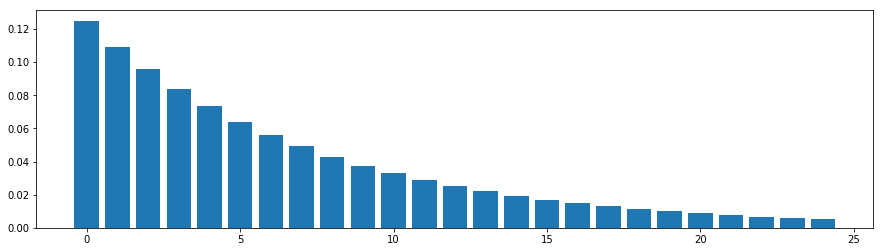

In [2]:
n=15
plt.figure(figsize=(15,4))
alpha = 2/(n+1)
series = pd.Series([alpha * (1-alpha)**i for i in range(n+10)])
plt.bar(left=range(n+10), height=series)

plt.show()

##### EMAの特長

- 最新のデータの重み係数が最も大きく、データが古くなると重み係数が指数関数的に減少していく
    - n が小さいことを「速い」、大きいことを「遅い」という

### 観測値 fi のバラツキについても考える

以前出た式、

$$
\begin{eqnarray}
\Delta f_i = f_i-f_{i-1}
\end{eqnarray}
$$
の 
$$
\begin{eqnarray}
f_{i-1} 
\end{eqnarray}
$$
をEMAに置き換える。
$$
\begin{eqnarray}
\\f_i-\mathrm{EMA}_i^{(n)}
\end{eqnarray}
$$

以前よりも、データの時間的な影響度が考慮された指標になっているものの、今現在のデータ（*f<sub>i</sub>*）のばらつきは考慮できていないので、こっちもEMAで置き換える。置き換えたものは、**移動平均線収束拡散法（MACD）**の主要部になる。MACDは、株価や為替市場のトレンド分析などで使われる。（ただし、n1 < n2 )
    
$$
\begin{eqnarray}
\mathrm{MACD}_i^{(n_1,n_2)} = \mathrm{EMA}_i^{(n_1)}-\mathrm{EMA}_i^{(n_2)}
\end{eqnarray}
$$
（ただし、n1 < n2 )

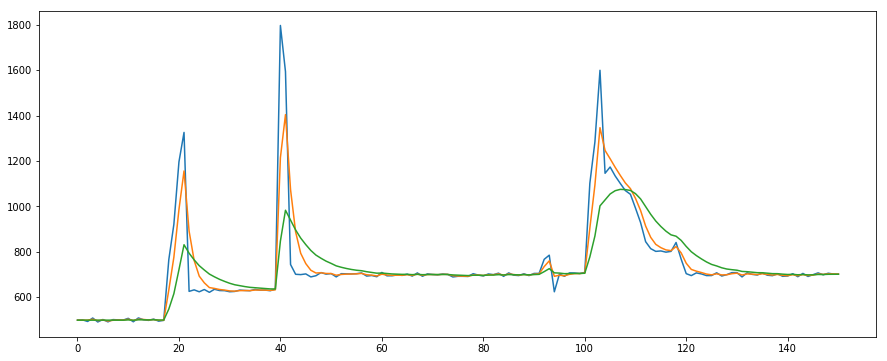

In [41]:
# データを実際に入れて、n = 3のときと n = 10の時のグラフの差を見る
plt.figure(figsize=(15,6))
data = [500,501.2643237,494.138763,509.448287,492.0069485,502.824497,492.4755806,502.4215286,501.3930536,500.2121231,508.0601945,492.8630916,509.821828,501.8913618,499.0294993,504.7704745,495.4857502,499.245443,765.9743944,921.6761626,1196.223427,1325.742419,626.6498194,633.2977621,624.7691034,634.764256,622.4083525,635.8466715,630.2125259,629.7358964,624.9750743,626.2918018,632.246212,630.5486329,629.5355411,635.0764469,631.9483051,632.1246105,629.5898863,636.1574359,1796.1792,1593.325019,744.7143974,701.7554387,700.3469492,703.4025619,690.2011427,695.3506947,709.3112029,702.4168599,704.7538729,690.3022894,704.425951,703.7565259,703.3205978,704.3533939,707.6587862,693.8585065,696.4343437,690.9460457,709.7699602,695.047891,695.3416699,698.7896414,696.9931224,702.4033044,693.7832213,707.7759585,692.9457656,703.620825,700.7996238,699.1441136,703.0565475,700.9799117,690.0157736,692.9265688,692.8469195,692.2275211,704.2733942,698.2237595,694.349252,703.2657442,700.0936642,706.8061183,692.7235122,707.8955518,697.885353,696.1725397,704.0645553,695.9932076,705.5038454,705.6130033,767.5515254,785.8684895,624.8102414,702.3319886,692.9441699,707.9685579,707.4447453,705.1355072,709.9609769,1101.826764,1284.081422,1598.999264,1146.008161,1173.596854,1134.110732,1101.461717,1070.003183,1053.664991,992.6139369,929.4326997,845.1270378,814.4865432,802.4981715,804.4548871,799.0838476,802.507634,841.6629941,768.3556762,704.5473972,695.9699889,707.8734113,703.2996991,696.0423092,696.1571369,708.3073957,694.1615909,700.2558821,709.0422342,709.1811679,690.2329495,708.1387974,701.404179,698.598151,707.5987617,697.6786559,695.6702275,703.7546632,692.8352122,694.2981405,704.3256225,691.2216893,705.5439582,692.168027,700.0882809,707.9291922,699.5773827,706.4417237,702.9299182,702.325706]
series = pd.Series(data)
plt.plot(series)

def ema(i, n, data):
    if i < n-1:
        return None
    
    elif i == n-1:
        num = 0
        for j in range(n):
            num += data[j]
            
        return num/n
    
    return 2/(n+1)*data[i] + (1 - (2/(n+1))) * ema(i-1, n, data)

series3 = pd.Series([500]*3 + [ ema(i, 3, data) for i in range(3, 151)])
plt.plot(series3)
series10 = pd.Series([500]*10 + [ ema(i, 10, data) for i in range(10, 151)])
plt.plot(series10)

plt.show()

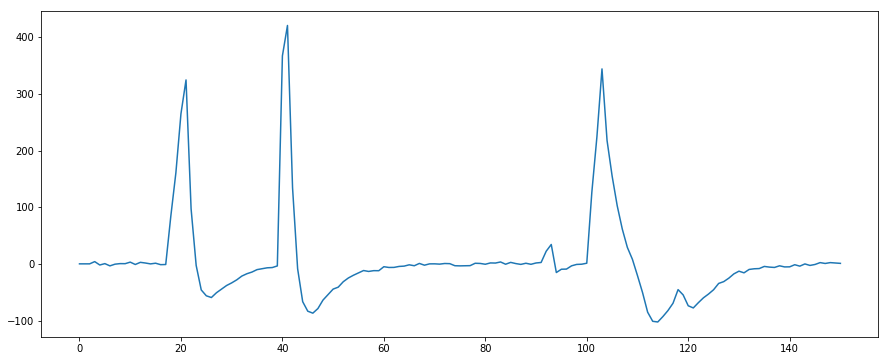

In [42]:
# 上で使ったデータから、MACD(3, 10)を表示させる
plt.figure(figsize=(15,6))
ema3 = [500]*3 + [ ema(i, 3, data) for i in range(3, 151)]
ema10 = pd.Series([500]*10 + [ ema(i, 10, data) for i in range(10, 151)])
macd3_10 = [ ema3[i] - ema10[i] for i in range(151) ]
plt.plot(pd.Series(macd3_10))
plt.show()

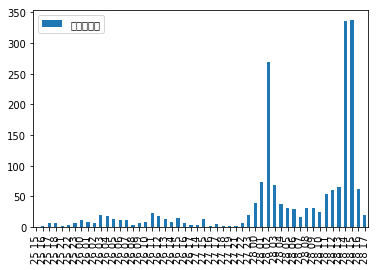

In [47]:
import codecs
import re
from collections import defaultdict

match_pattern = re.compile(r"\A[A-Z][a-z]{2} [A-Z][a-z]{2} ([0-9]{2} [0-9]{2}).*$")
counter = defaultdict(int)

with codecs.open("ゲームオブスローンズ.txt", "r", "utf-8") as fp:
    for line in fp:
        counter[match_pattern.match(line).groups()[0]] += 1

tweet_data = pd.DataFrame.from_dict({"つぶやき数": counter})

tweet_data.plot.bar()
plt.show()

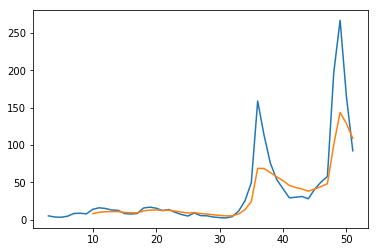

In [55]:
data = [ t[1] for t in sorted(counter.items())]
series3 = pd.Series([None]*3 + [ ema(i, 3, data) for i in range(3, len(data))])
plt.plot(series3)
series10 = pd.Series([None]*10 + [ ema(i, 10, data) for i in range(10, len(data))])
plt.plot(series10)

plt.show()

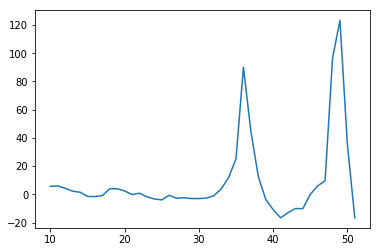

In [59]:
ema3 = [None]*3 + [ ema(i, 3, data) for i in range(3,  len(data))]
ema10 = pd.Series([None]*10 + [ ema(i, 10, data) for i in range(10,  len(data))])
macd3_10 = [None]*10 + [ ema3[i] - ema10[i] for i in range(10,  len(data)) ]
plt.plot(pd.Series(macd3_10))
plt.show()